In [1]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models

Hop size - 160 
Window Size - 512 
fft_size = 512

In [2]:
def preprocess_data(file_path, max_time_steps=109, sample_rate=22050, duration=3, n_mels=128):
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

In [3]:
# Set your file paths and constants
TRAINING_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
TRAINING_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
VALIDATION_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac'
VALIDATION_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
SAMPLE_RATE = 22050  # Adjust if your sample rate is different
DURATION = 3  # Adjust the duration of your audio samples
N_MELS = 128  # Adjust the number of mel filters

In [4]:
# Load labels for training Data
train_labels = {}

with open(TRAINING_LABEL, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    train_labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in train_labels.items():
    file_path = os.path.join(TRAINING_DATA, file_name + ".flac")

    # Use the preprocess_data function
    mel_spectrogram = preprocess_data(file_path, max_time_steps=max_time_steps)

    X.append(mel_spectrogram)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Reshape input data to match the required input shape for ResNet
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

In [5]:
# Define input shape and number of classes
input_shape = X[0].shape
num_classes = 2  # Assuming you have two classes (0 and 1)

In [6]:
# Load and preprocess evaluation data
eval_X = []
eval_y = []

with open(VALIDATION_LABEL, 'r') as eval_label_file:
    eval_lines = eval_label_file.readlines()

eval_labels = {}

for line in eval_lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    eval_labels[file_name] = label

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in eval_labels.items():
    file_path = os.path.join(VALIDATION_DATA, file_name + ".flac")

    # Use the preprocess_data function
    mel_spectrogram = preprocess_data(file_path, max_time_steps=max_time_steps)

    eval_X.append(mel_spectrogram)
    eval_y.append(label)

eval_X = np.array(eval_X)
eval_y = np.array(eval_y)


# Reshape input data to match the required input shape for ResNet
eval_X = eval_X.reshape((eval_X.shape[0], eval_X.shape[1], eval_X.shape[2], 1))

In [7]:
# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the ResNet model with a single node and sigmoid activation
def build_resnet(input_shape):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet blocks
    for size in [64, 128, 256, 512]:
        x = resnet_block(x, size, conv_shortcut=True)
        x = resnet_block(x, size)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)  # Change num_classes to 1 and use 'sigmoid' activation

    model = models.Model(inputs=input_tensor, outputs=x, name='resnet_model')
    return model

In [8]:
# Build ResNet model
resnet_model = build_resnet(input_shape)

2023-11-20 14:09:59.386286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 14:10:00.172113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22834 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-11-20 14:10:00.172736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22757 MB memory:  -> device: 1, name: NVIDIA TITAN RTX, pci bus id: 0000:68:00.0, compute capability: 7.5


In [9]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Display the model summary
resnet_model.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 109, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 55, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 55, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [12]:
# Train the model
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

epochs = 50  # Adjust the number of epochs as needed

history = resnet_model.fit(X_train, y_train, epochs=epochs, validation_data=(eval_X, eval_y))



Epoch 1/50


2023-11-20 14:10:18.555459: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-11-20 14:10:19.065908: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


635/635 [==============================] - 82s 123ms/step - loss: 0.1606 - accuracy: 0.9362 - val_loss: 2.6824 - val_accuracy: 0.8974
Epoch 2/50
635/635 [==============================] - 76s 120ms/step - loss: 0.0867 - accuracy: 0.9675 - val_loss: 6.3786 - val_accuracy: 0.8974
Epoch 3/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0557 - accuracy: 0.9798 - val_loss: 2.2882 - val_accuracy: 0.6290
Epoch 4/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0359 - accuracy: 0.9867 - val_loss: 0.1326 - val_accuracy: 0.9509
Epoch 5/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0522 - val_accuracy: 0.9849
Epoch 6/50
635/635 [==============================] - 77s 121ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0585 - val_accuracy: 0.9797
Epoch 7/50
635/635 [==============================] - 77s 122ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.9556 - val_accuracy: 0.8

AttributeError: 'History' object has no attribute 'evaluate'

In [13]:
# Evaluate the model on the test set
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Evaluate the model on the separate evaluation dataset
eval_loss, eval_accuracy = resnet_model.evaluate(eval_X, eval_y)
print(f'Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy * 100:.2f}%')

  3/159 [..............................] - ETA: 5s - loss: 0.6821 - accuracy: 0.9167

159/159 [==============================] - 5s 32ms/step - loss: 0.1169 - accuracy: 0.9681
Test Loss: 0.1169, Test Accuracy: 96.81%
777/777 [==============================] - 24s 30ms/step - loss: 0.0889 - accuracy: 0.9783
Evaluation Loss: 0.0889, Evaluation Accuracy: 97.83%


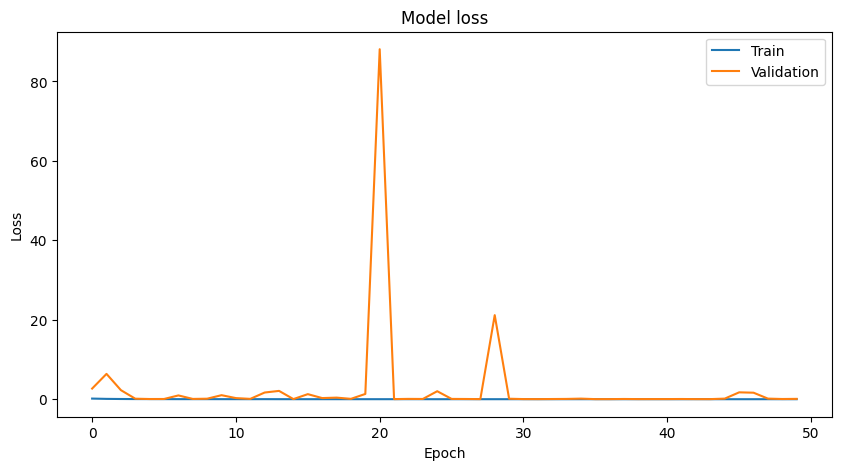

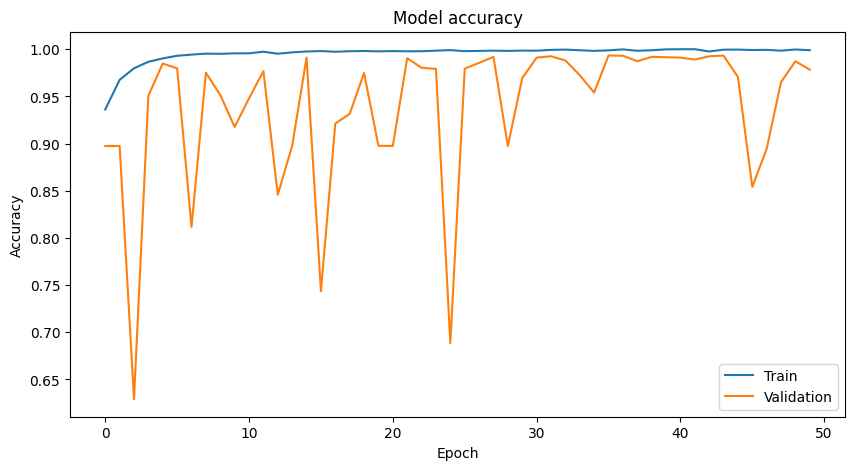

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [15]:
# Save the trained model
resnet_model.save("models/basic_resnet_sigmoid.h5")